In [1]:
! pip install sklearn-pandas
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
import torchtuples as tt # Some useful functions
# change pycox import datasets and df= read.csv

df_train=pd.read_csv('D:/UNOS_NEW/waitt_dephit_train_cindex7.csv', sep=',')
df_test=pd.read_csv('D:/UNOS_NEW/waitt_dephit_test_cindex7.csv', sep=',')
df_val=pd.read_csv('D:/UNOS_NEW/waitt_dephit_val_cindex7.csv', sep=',')
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv
## Uncomment to install `sklearn-pandas`
# ! pip install sklearn-pandas
np.random.seed(1234)
_ = torch.manual_seed(123)

df_train['INIT_AGE']=df_train['INIT_AGE'].astype('float32')
df_train['INIT_BILIRUBIN']=df_train['INIT_BILIRUBIN'].astype('float32')
df_train['INIT_INR']=df_train['INIT_INR'].astype('float32')
df_train['INIT_SERUM_CREAT']=df_train['INIT_SERUM_CREAT'].astype('float32')
df_train['FUNC_STAT_TCR']=df_train['FUNC_STAT_TCR'].astype('float32')
df_train['INIT_ALBUMIN']=df_train['INIT_ALBUMIN'].astype('float32')
df_train['INIT_ASCITES']=df_train['INIT_ASCITES'].astype('float32')
df_train['LIFE_SUP_TCR']=df_train['LIFE_SUP_TCR'].astype('float32')
df_train['INIT_ENCEPH']=df_train['INIT_ENCEPH'].astype('float32')
df_train['VENTILATOR_TCR']=df_train['VENTILATOR_TCR'].astype('float32')
df_train['duration']=df_train['duration'].astype('float32')
df_train['event']=df_train['event'].astype('int32')

df_test['INIT_AGE']=df_test['INIT_AGE'].astype('float32')
df_test['INIT_BILIRUBIN']=df_test['INIT_BILIRUBIN'].astype('float32')
df_test['INIT_INR']=df_test['INIT_INR'].astype('float32')
df_test['INIT_SERUM_CREAT']=df_test['INIT_SERUM_CREAT'].astype('float32')
df_test['FUNC_STAT_TCR']=df_test['FUNC_STAT_TCR'].astype('float32')
df_test['INIT_ALBUMIN']=df_test['INIT_ALBUMIN'].astype('float32')
df_test['INIT_ASCITES']=df_test['INIT_ASCITES'].astype('float32')
df_test['LIFE_SUP_TCR']=df_test['LIFE_SUP_TCR'].astype('float32')
df_test['INIT_ENCEPH']=df_test['INIT_ENCEPH'].astype('float32')
df_test['VENTILATOR_TCR']=df_test['VENTILATOR_TCR'].astype('float32')
df_test['duration']=df_test['duration'].astype('float32')
df_test['event']=df_test['event'].astype('int32')

df_val['INIT_AGE']=df_val['INIT_AGE'].astype('float32')
df_val['INIT_BILIRUBIN']=df_val['INIT_BILIRUBIN'].astype('float32')
df_val['INIT_INR']=df_val['INIT_INR'].astype('float32')
df_val['INIT_SERUM_CREAT']=df_val['INIT_SERUM_CREAT'].astype('float32')
df_val['FUNC_STAT_TCR']=df_val['FUNC_STAT_TCR'].astype('float32')
df_val['INIT_ALBUMIN']=df_val['INIT_ALBUMIN'].astype('float32')
df_val['INIT_ASCITES']=df_val['INIT_ASCITES'].astype('float32')
df_val['LIFE_SUP_TCR']=df_val['LIFE_SUP_TCR'].astype('float32')
df_val['INIT_ENCEPH']=df_val['INIT_ENCEPH'].astype('float32')
df_val['VENTILATOR_TCR']=df_val['VENTILATOR_TCR'].astype('float32')
df_val['duration']=df_val['duration'].astype('float32')
df_val['event']=df_val['event'].astype('int32')

In [2]:
import numpy as np
import pandas as pd

class OrderedCategoricalLong:
    """Transform pandas series or numpy array to categorical, and get (long) values,
    i.e. index of category. Useful for entity embeddings.
    Zero is reserved for unknown categories or nans.
    Keyword Arguments:
        min_per_category {int} -- Number of instances required to not be set to nan (default: {20})
        return_series {bool} -- If return a array or pd.Series (default: {False})
    
    Returns:
        [pd.Series] -- Series with long values reffering to categories.
    """
    def __init__(self, min_per_category=20, return_series=False):
        
        self.min_per_category = min_per_category
        self.return_series = return_series

    def fit(self, series, y=None):
        series = pd.Series(series).copy()
        smaller = series.value_counts() < self.min_per_category
        values = smaller[smaller].index.values
        for v in values:
            series[series == v] = np.nan
        self.categories = series.astype('category').cat.categories
        return self
    
    def transform(self, series, y=None):
        series = pd.Series(series).copy()
        transformed = pd.Categorical(series, categories=self.categories, ordered=True)
        transformed = pd.Series(transformed, index=series.index)
        transformed = transformed.cat.codes.astype('int64') + 1
        return transformed if self.return_series else transformed.values
    
    def fit_transform(self, series, y=None):
        return self.fit(series, y).transform(series, y)
cols_std = ['INIT_AGE','INIT_ALBUMIN', 'INIT_BILIRUBIN', 'INIT_INR', 'INIT_SERUM_CREAT'] # numeric variables
cols_bin = ['LIFE_SUP_TCR','VENTILATOR_TCR'] # binary variables
cols_cat = ['FUNC_STAT_TCR','INIT_ASCITES','INIT_ENCEPH'] # categorical variables

standardize = [([col], StandardScaler()) for col in cols_std]
leave = [(col, None) for col in cols_bin]
categorical = [(col, OrderedCategoricalLong()) for col in cols_cat]

x_mapper_float = DataFrameMapper(standardize + leave)
x_mapper_long = DataFrameMapper(categorical)  # we need a separate mapper to convert data to 'int64'

x_fit_transform = lambda df: tt.tuplefy(x_mapper_float.fit_transform(df), x_mapper_long.fit_transform(df))
x_transform = lambda df: tt.tuplefy(x_mapper_float.transform(df), x_mapper_long.transform(df))

x_train = x_fit_transform(df_train)
x_val = x_transform(df_val)
x_test = x_transform(df_test)

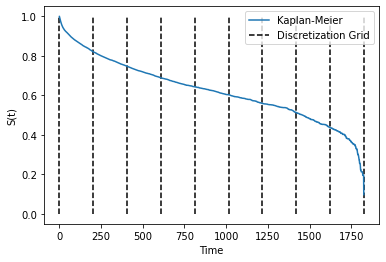

In [3]:
num_durations = 10
scheme = 'equidistant' # or quantiles
labtrans = DeepHitSingle.label_transform(num_durations, scheme)
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

# Plotting discrete intervals
from pycox.utils import kaplan_meier
plt.vlines(labtrans.cuts, 0, 1, colors='black', linestyles="--", label='Discretization Grid')
kaplan_meier(*get_target(df_train)).plot(label='Kaplan-Meier')
plt.ylabel('S(t)')
plt.legend()
_ = plt.xlabel('Time')

In [4]:
num_embeddings = x_train[1].max(0) + 1
embedding_dims = num_embeddings // 2

in_features = x_train[0].shape[1]
out_features = labtrans.out_features
num_nodes = [64, 64]
batch_norm = True
dropout = 0.3

net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims,
                                 num_nodes, out_features, batch_norm, dropout)
                                 
optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2)

model = DeepHitSingle(net, optimizer, duration_index=labtrans.cuts)

In [5]:
batch_size = 700
lrfind = model.lr_finder(x_train, y_train, batch_size, tolerance=50)
lrfind.get_best_lr()

C:\Users\xiaoz\anaconda3\lib\site-packages\torchtuples\callbacks.py:607: UserWarning: This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:1050.)
  p.data = p.data.add(-weight_decay * eta, p.data)


0.08902150854450441

In [6]:
model.optimizer.set_lr(0.089)

In [7]:
epochs = 100
callbacks = [tt.cb.EarlyStoppingCycle()]
verbose = True 

log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val)

0:	[0s / 0s],		train_loss: 0.8501,	val_loss: 0.4366
1:	[0s / 0s],		train_loss: 0.6396,	val_loss: 0.7067
2:	[0s / 0s],		train_loss: 0.5222,	val_loss: 0.4361
3:	[0s / 0s],		train_loss: 0.4239,	val_loss: 0.3458
4:	[0s / 0s],		train_loss: 0.3589,	val_loss: 0.2957
5:	[0s / 0s],		train_loss: 0.3971,	val_loss: 0.3094
6:	[0s / 1s],		train_loss: 0.3325,	val_loss: 0.3070
7:	[0s / 1s],		train_loss: 0.3206,	val_loss: 0.2869
8:	[0s / 1s],		train_loss: 0.3107,	val_loss: 0.2652
9:	[0s / 1s],		train_loss: 0.2890,	val_loss: 0.2673
10:	[0s / 1s],		train_loss: 0.2701,	val_loss: 0.2517
11:	[0s / 1s],		train_loss: 0.2635,	val_loss: 0.2575
12:	[0s / 2s],		train_loss: 0.2564,	val_loss: 0.2486
13:	[0s / 2s],		train_loss: 0.2549,	val_loss: 0.2480
14:	[0s / 2s],		train_loss: 0.2546,	val_loss: 0.2477
15:	[0s / 2s],		train_loss: 0.3008,	val_loss: 0.3104
16:	[0s / 2s],		train_loss: 0.2943,	val_loss: 0.2622
17:	[0s / 2s],		train_loss: 0.2565,	val_loss: 0.2463
18:	[0s / 2s],		train_loss: 0.2445,	val_loss: 0.2523
19:

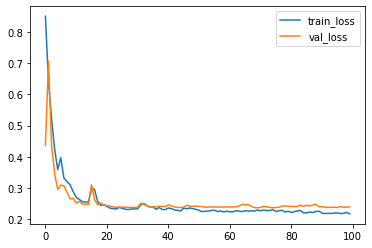

In [8]:
_ = log.plot()

In [9]:
surv = model.predict_surv_df(x_test)

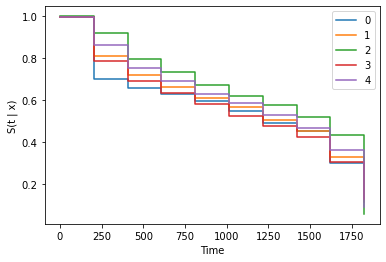

In [10]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [11]:
surv = model.interpolate(10).predict_surv_df(x_test)

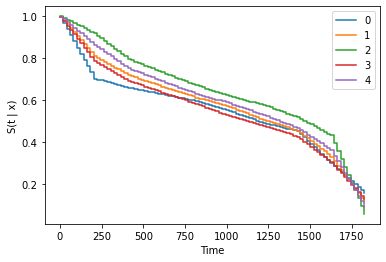

In [12]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [13]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [14]:
ev.concordance_td('antolini')

0.764066532012685

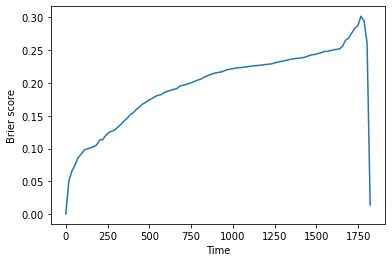

In [15]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

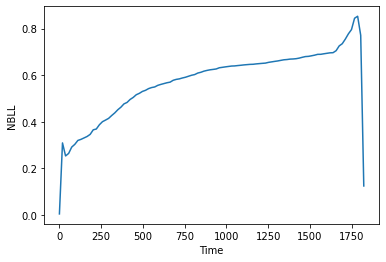

In [16]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [17]:
ev.integrated_brier_score(time_grid) 

0.19698739313595118

In [18]:
ev.integrated_nbll(time_grid) 

0.5762674939285989

In [19]:
df_predict=pd.read_csv('D:/UNOS_NEW/dat_imp_waitt_deep.csv', sep=',')

df_predict['INIT_AGE']=df_predict['INIT_AGE'].astype('float32')
df_predict['INIT_BILIRUBIN']=df_predict['INIT_BILIRUBIN'].astype('float32')
df_predict['INIT_INR']=df_predict['INIT_INR'].astype('float32')
df_predict['INIT_SERUM_CREAT']=df_predict['INIT_SERUM_CREAT'].astype('float32')
df_predict['FUNC_STAT_TCR']=df_predict['FUNC_STAT_TCR'].astype('float32')
df_predict['INIT_ALBUMIN']=df_predict['INIT_ALBUMIN'].astype('float32')
df_predict['INIT_ASCITES']=df_predict['INIT_ASCITES'].astype('float32')
df_predict['LIFE_SUP_TCR']=df_predict['LIFE_SUP_TCR'].astype('float32')
df_predict['INIT_ENCEPH']=df_predict['INIT_ENCEPH'].astype('float32')
df_predict['VENTILATOR_TCR']=df_predict['VENTILATOR_TCR'].astype('float32')

In [20]:
x_test = x_transform(df_predict)

In [21]:
x_predict = x_transform(df_predict)

In [22]:
surv = model.interpolate(10).predict_surv_df(x_predict)

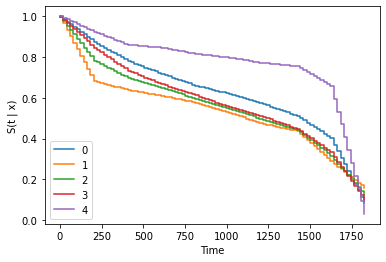

In [23]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [24]:
surv

,0,1,2,3,4,5,6,7,8,9,...,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
0.000000,0.999086,0.997657,0.997577,0.998348,0.999946,0.998470,0.999147,0.998388,0.998823,0.997400,...,0.998007,0.998240,0.997965,0.998318,0.999486,0.998218,0.998867,0.997956,0.998956,0.997930
20.277777,0.986545,0.965881,0.975983,0.983072,0.992375,0.984836,0.987441,0.984123,0.987266,0.983389,...,0.982899,0.981937,0.982870,0.982432,0.991408,0.984474,0.983515,0.976871,0.991569,0.975535
40.555554,0.974005,0.934106,0.954388,0.967795,0.984804,0.971201,0.975734,0.969858,0.975709,0.969379,...,0.967790,0.965633,0.967775,0.966546,0.983330,0.970730,0.968164,0.955786,0.984181,0.953140
60.833331,0.961464,0.902330,0.932793,0.952519,0.977232,0.957567,0.964028,0.955593,0.964152,0.955368,...,0.952682,0.949329,0.952680,0.950660,0.975251,0.956986,0.952813,0.934700,0.976793,0.930745
81.111108,0.948924,0.870554,0.911198,0.937243,0.969661,0.943932,0.952322,0.941328,0.952595,0.941358,...,0.937574,0.933026,0.937585,0.934774,0.967173,0.943243,0.937462,0.913615,0.969405,0.908350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1743.888867,0.209939,0.209605,0.199036,0.191414,0.281326,0.199172,0.205501,0.193850,0.194070,0.192575,...,0.202304,0.194823,0.194022,0.197205,0.199526,0.195566,0.210843,0.201680,0.183018,0.203822
1764.166650,0.177931,0.196452,0.179438,0.167844,0.218526,0.172058,0.172808,0.168751,0.164615,0.167194,...,0.176125,0.171414,0.169565,0.172706,0.163640,0.169577,0.181872,0.180444,0.149673,0.183593
1784.444434,0.145923,0.183299,0.159839,0.144275,0.155727,0.144944,0.140115,0.143651,0.135160,0.141813,...,0.149946,0.148006,0.145107,0.148206,0.127755,0.143587,0.152900,0.159209,0.116329,0.163364
1804.722217,0.113914,0.170146,0.140240,0.120705,0.092927,0.117830,0.107421,0.118552,0.105705,0.116431,...,0.123767,0.124597,0.120650,0.123706,0.091869,0.117598,0.123928,0.137974,0.082984,0.143134


In [25]:
surv.to_pickle("D:/UNOS_NEW/wait_surv_mas.pkl")

In [26]:
unpickled_surv_wait_mas=pd.read_pickle("D:/UNOS_NEW/wait_surv_mas.pkl")
unpickled_surv_wait_mas

,0,1,2,3,4,5,6,7,8,9,...,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
0.000000,0.999086,0.997657,0.997577,0.998348,0.999946,0.998470,0.999147,0.998388,0.998823,0.997400,...,0.998007,0.998240,0.997965,0.998318,0.999486,0.998218,0.998867,0.997956,0.998956,0.997930
20.277777,0.986545,0.965881,0.975983,0.983072,0.992375,0.984836,0.987441,0.984123,0.987266,0.983389,...,0.982899,0.981937,0.982870,0.982432,0.991408,0.984474,0.983515,0.976871,0.991569,0.975535
40.555554,0.974005,0.934106,0.954388,0.967795,0.984804,0.971201,0.975734,0.969858,0.975709,0.969379,...,0.967790,0.965633,0.967775,0.966546,0.983330,0.970730,0.968164,0.955786,0.984181,0.953140
60.833331,0.961464,0.902330,0.932793,0.952519,0.977232,0.957567,0.964028,0.955593,0.964152,0.955368,...,0.952682,0.949329,0.952680,0.950660,0.975251,0.956986,0.952813,0.934700,0.976793,0.930745
81.111108,0.948924,0.870554,0.911198,0.937243,0.969661,0.943932,0.952322,0.941328,0.952595,0.941358,...,0.937574,0.933026,0.937585,0.934774,0.967173,0.943243,0.937462,0.913615,0.969405,0.908350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1743.888867,0.209939,0.209605,0.199036,0.191414,0.281326,0.199172,0.205501,0.193850,0.194070,0.192575,...,0.202304,0.194823,0.194022,0.197205,0.199526,0.195566,0.210843,0.201680,0.183018,0.203822
1764.166650,0.177931,0.196452,0.179438,0.167844,0.218526,0.172058,0.172808,0.168751,0.164615,0.167194,...,0.176125,0.171414,0.169565,0.172706,0.163640,0.169577,0.181872,0.180444,0.149673,0.183593
1784.444434,0.145923,0.183299,0.159839,0.144275,0.155727,0.144944,0.140115,0.143651,0.135160,0.141813,...,0.149946,0.148006,0.145107,0.148206,0.127755,0.143587,0.152900,0.159209,0.116329,0.163364
1804.722217,0.113914,0.170146,0.140240,0.120705,0.092927,0.117830,0.107421,0.118552,0.105705,0.116431,...,0.123767,0.124597,0.120650,0.123706,0.091869,0.117598,0.123928,0.137974,0.082984,0.143134
